In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns 
import scipy
import math
import random 
from scipy import stats
import statistics
import math 

In [4]:
#this makes it so that the WHOLE dataframe prints - will crash your browser if used too liberally 

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', 199)  # or 199

In [5]:
random.seed(1)

### Load the data

In [6]:
#columns that aren't needed 
drop_cols = ['Unnamed: 0', 'Allowed', 'Subject', 'StudioVersion', 
             'leftarrow', 'rightarrow', 'triggercode', 'Clock.Information', 
             'DataFile.Basename', 'Display.RefreshRate', 'Procedure[Block]', 
             'Procedure[Trial]', 'RandomSeed', 'Running[Block]', 
             'Running[SubTrial]', 'Running[Trial]', 'RuntimeCapabilities', 
             'RuntimeVersion', 'RuntimeVersionExpected']


SST_cleaned_7231.csv is the trial by trial event data that's been run through clean_SST.ipynb

In [7]:
SST_concat = pd.read_csv('SST_cleaned_7231.csv').drop(drop_cols, 
                                                      axis =1)

/Users/work/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,15,38,82,105,115,116) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### A few qa checks: 

In [8]:
#check these values - they shouldn't be over 1000ms 
sum(SST_concat['go_stim_duration'] > 1000)

0

In [14]:
#check len of dataframe to make sure it all got loaded 
assert len(SST_concat) == 2603160

In [10]:
#assertion about stop_rt_adjusted and go_rt_adjusted

In [11]:
#build in a few more here - for trial code correctness and 

### Issue 1:  Different go stimulus duration across 

##### On go trials, the go Stimulus is displayed for 1000ms, or RT, whichever comes first. On stop trials, the go stimulus is displayed for the duration of the stop signal delay (range: 0ms - 900ms), or RT, whichever comes first. 

In [18]:
#use groupby method to do computations within participants 
group_narguid = SST_concat.groupby('NARGUID')

In [34]:
narguid_stop_duration = group_narguid.apply(lambda x: 
                                            np.mean(x.loc[x['trial_type'] == 'StopTrial']
                                            ['go_stim_duration']))

In [23]:
narguid_stop_duration[:10] #preview of a few of these 

NARGUID
003RTV85    314.083333
00CY2MDM     71.933333
00HEV6HB    161.483333
00LJVZK2    235.950000
00NPMHND    491.583333
00R4TXET    218.333333
00UMK5VC    258.633333
00X2TBWJ    307.866667
010ZM3H9     16.333333
0191C80U    159.166667
dtype: float64

In [36]:
narguid_go_duration = group_narguid.apply(lambda x: 
                                          np.mean(x.loc[x['trial_type'] == 'GoTrial']['go_stim_duration']))

In [24]:
narguid_go_duration[:10] #preview 

NARGUID
003RTV85    647.570000
00CY2MDM    492.936667
00HEV6HB    463.266667
00LJVZK2    767.306667
00NPMHND    803.490000
00R4TXET    493.933333
00UMK5VC    580.193333
00X2TBWJ    582.603333
010ZM3H9    493.036667
0191C80U    605.026667
dtype: float64

##### Figure 1. Histogram of Go Stimulus Durations on Go and Stop Trials

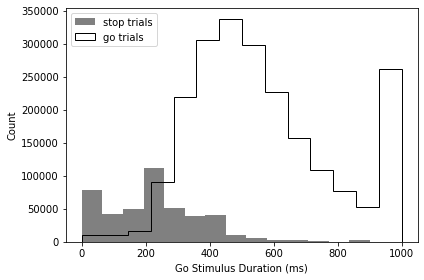

In [30]:
plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'StopTrial'].dropna(), 
         bins = 14, label = "stop trials", color = 'grey')
plt.xlabel('Go Stimulus Duration (ms)')
plt.ylabel('Count')

plt.hist(SST_concat['go_stim_duration'].loc[SST_concat['trial_type'] == 'GoTrial'].dropna(), 
         bins = 14, histtype='step',
         label = "go trials", color = 'black')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('go_stim_duration.png')
plt.show()

Difference of average participant go duration on go trials and stop trials

In [29]:
np.mean(narguid_go_duration) - np.mean(narguid_stop_duration)

340.6331825934649

A longer STop Failure RT is 

let's look at the averages by participant now: 

##### Comparing stop failure reaction time and overt go response reaction time is a conservative indication of whether context independence, a necessary assumption when modeling stop signal reaction time is being violated.  

In [42]:
narguid_average_stop_rt = group_narguid.apply(lambda x: 
                                                np.mean(x.loc[x['correct_stop'] == 0]['stop_rt_adjusted']))

In [43]:
print('stop failure rt:', np.mean(narguid_average_stop_rt))
print('sdev:', np.std(narguid_average_stop_rt))   

stop failure rt: 495.01266545367145
sdev: 139.96034292909457


In [44]:
narguid_average_go_rt = group_narguid.apply(lambda x: np.mean(x.loc[(x['correct_go_response'] != 'omission') 
                                                                    & (x['trial_type'] == 'GoTrial')]['go_rt_adjusted']))

In [45]:
print('overt go response mean:', np.mean(narguid_average_go_rt))
print('sdev:', np.std(narguid_average_go_rt))

overt go response mean: 543.6630781157475
sdev: 95.29722256609477


In [57]:
print('difference beween these:', np.mean(narguid_average_stop_rt) - np.mean(narguid_average_go_rt))

difference beween these: -48.65041266207601


##### Compare stop failure rt and go rt within participants: 

In [48]:
#get number of participants who have longer stop failure rt
print(sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)))

#divide by number of participants
sum(np.greater(narguid_average_stop_rt, narguid_average_go_rt)) / len(SST_concat['NARGUID'].unique())

1326


0.18337712626192781

##### Another way that shorter go stimulus durations can effect the go process is in the choice response

In [50]:
def stop_fail_accuracy(df):
    try: 
        acc = len(df.loc[df['correct_stop_mapping'] == 1]) / len(df.loc[df['correct_stop'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    return acc                                         

In [51]:
#make a dataframe of rts 
narguid_df = pd.DataFrame({'stop_rt': narguid_average_stop_rt,'go_rt':narguid_average_go_rt})

#add accuracies to that dataframe
narguid_df['stop_acc'] = np.NaN
narguid_df['go_acc'] = np.NaN

narguid_df['go_acc'] = group_narguid.apply(lambda x: len(x.loc[x['correct_go_response'] == '1.0']) /
                                          len(x.loc[(x['correct_go_response'] != 'omission') & (x['trial_type'] == 'GoTrial')]))

narguid_df['stop_acc'] = group_narguid.apply(lambda x: stop_fail_accuracy(x))

#if a participant had no stop failures, then they need to be dropped 
narguid_df = narguid_df.dropna(how='any')

calculate CI for the difference between go_rt and stop_rt

In [52]:
mu = np.mean(narguid_df['go_rt'] - narguid_df['stop_rt'])
N = len(narguid_df)
sigma = np.std(narguid_df['go_rt'] - narguid_df['stop_rt'])
stats.norm.interval(0.95, loc=mu, scale=sigma/math.sqrt(N))


(46.559456555770865, 50.76564197295882)

calculate CI for the difference between stop_acc and go_acc

In [54]:
mu = np.mean(narguid_df['stop_acc'] - narguid_df['go_acc'])
N = len(narguid_df)
sigma = np.std(narguid_df['stop_acc'] - narguid_df['go_acc'])
stats.norm.interval(.95, loc=mu,scale=sigma/math.sqrt(N))

(-0.11187416423722574, -0.10639848790163689)

##### choice accuracy across SSDs 

In [53]:
ssd_acc_df = group_narguid.apply(lambda x: x.groupby('SSDDur').apply(lambda x: stop_fail_accuracy(x))) 

In [54]:
average_ssd_acc = ssd_acc_df.groupby('SSDDur').apply(lambda x: np.mean(x))

##### Figure 2. Choice response accuracy on stop-failure trials across SSD


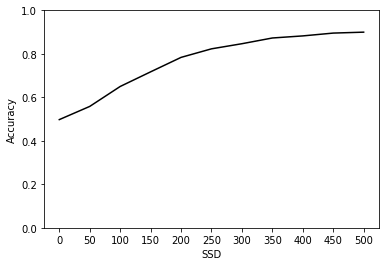

In [55]:
plt.plot(average_ssd_acc.iloc[:-8], color='black')
plt.ylim(0, 1)
plt.xticks(np.arange(0, 550, 50))
plt.ylabel('Accuracy')
plt.xlabel('SSD')
plt.savefig('accuracy_accross_ssd.png')
plt.show()

### Issue 2: Go Stimulus sometimes not presented

On trials where SSD is 0, the Go stimulus is not presented. 

In [59]:
len(SST_concat.loc[SST_concat['SSDDur'] == 0])/\
    len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])

0.09017194486700779

The stop accuracy of these should be high, due to the stop process not being handicapped. 

In [61]:
def zero_SSD_acc(df): 
    try: 
        acc = len(df.loc[(df['SSDDur'] == 0) & (df['correct_stop'] == 1.0)]) / len(df.loc[df['SSDDur'] == 0])
    except ZeroDivisionError:
        acc = np.NaN
    
    return acc                     

In [62]:
zero_acc = group_narguid.apply(lambda x: zero_SSD_acc(x))

In [64]:
np.mean(zero_acc)

0.6045009332058497

##### Figure 3. Histogram of Stop-Signal Delays   


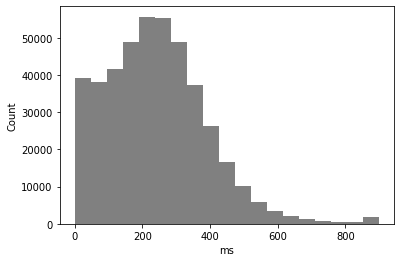

In [65]:
plt.hist(SST_concat['SSDDur'].dropna(), bins = len(SST_concat['SSDDur'].dropna().unique()), color='grey')
plt.xlabel('ms') #fix xlabel, ylabel 
#plt.title('Distribution of Stop Signal Delays')
plt.ylabel('Count')
#plt.axvline(x=mean_SSD, color = 'r', label = "mean SSD")
#plt.legend()
plt.savefig('stop_signal_duration_hist.png')
plt.show() #needs error bars 

### Issue 3: Faulty stop-signal delays



In [ ]:
#uncomment to look at the relevant columns 
# SST_concat.loc[(SST_concat['SSD.RT'] < 100) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]\
#      [['NARGUID', 'TrialNum', 'SSD.RT', 'SSD.RESP', 'SSDDur' ]]

In [72]:
SSD_bug = SST_concat.loc[(SST_concat['SSD.RT'] < 50) & (SST_concat['SSD.RT'] > 0) & (SST_concat['SSDDur'] <=50)]['NARGUID']# \

In [ ]:
#uncomment to print to a csv and view 
# pd.DataFrame(SSD_bug.unique()).to_csv('SSD_bug.csv')

In [73]:
len(SSD_bug.unique())/ 7231  #percent of subjects with this issue 

0.027243811367722307

In [74]:
len(SSD_bug) / len(SST_concat) #percent of trials this impacts 

0.0021101276909602177

In [77]:
#drops the prob narguids and regroups by SSD
drop_zero_ssd_group = SST_concat.set_index('NARGUID').drop(SSD_bug.unique()).groupby('NARGUID')

Recalculate accuracy with these subjects dropped 

In [79]:
drop_zero_acc = drop_zero_ssd_group.apply(lambda x: zero_SSD_acc(x))

In [80]:
np.mean(drop_zero_acc)

0.6311580931217083

### Issue 4: Different stop signal stimulus duration for different SSDs

Stop signal stimulus duration persists for 300ms, unless the go stimulus was presented for over 700 ms, in which case it's presented for 1000 - go stimulus duration, leading to differences in the duration of the stop signal stimulus across SSDs. 

In [70]:
len(SST_concat.loc[SST_concat['SSDDur'] > 700]) / len(SST_concat.loc[SST_concat['trial_type'] =='StopTrial'])

0.008309131978057438

### Issue 5: Non-uniform conditional trial probabilities

The probability of a stop signal is not uniform, and stop trials never occur back to back, and rarely appear with one go trial in between. 

create random distribution where p(stop) = .167

In [ ]:
x = np.arange(0,20, 1)
def my_dist(i):
    i = (1/6) * (5/6)**(i)
    return(i)
p = my_dist(x)
p_norm = p/np.sum(p)  # norm to sum=1
p_cdf = np.cumsum(p_norm) # cumulative distribution
nsamples = 1000000
p_samp = []
rng = np.random.RandomState(1)
for i in range(nsamples):
    idx = np.where(p_cdf > rng.rand())[0]
    if len(idx) == 0:
        idx = p_cdf.shape[0] - 1
    else:
        idx = idx[0]
    p_samp.append(idx)

In [ ]:
stop_prob_index = SST_concat.loc[(SST_concat['StopTrial'] !=1) & (SST_concat['StopTrial'] !=31)].index

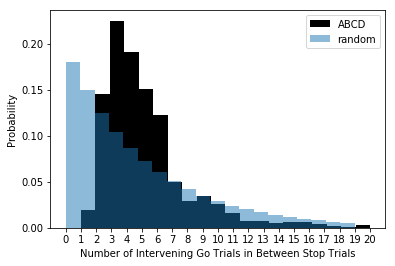

In [343]:
plt.hist(SST_concat['Stop_nback'].loc[stop_prob_index].dropna(), density = True, bins = 20, label = 'ABCD', color = 'black')
p_norm = p/np.sum(p)  # norm to sum=1
#plt.plot(x,p_norm, label = ‘random conditional probability of a stop signal’, color=‘r’)
ax = plt.gca()
plt.hist(p_samp, density = True, bins = 20, label = 'random', alpha=0.5)

plt.xlabel('Number of Intervening Go Trials in Between Stop Trials')
plt.ylabel('Probability')
#plt.title('Non-uniform conditional trial probabilities')
plt.xticks(np.arange(0, 21, step=1))
plt.legend()
plt.savefig('conditional_probability.png')
plt.show()


conditional probability of a stop signal, given a stop signal occured two trials ago

In [89]:
def mean_nback(df, num_back): 
    stop_prob_index = df.loc[(df['StopTrial'] !=1) & (df['StopTrial'] !=31)].index
    df = df.loc[stop_prob_index]
    nback_proportion =len(df.loc[df['Stop_nback'] == num_back]) / len(df.loc[df['trial_type'] == 'StopTrial'])
    return nback_proportion

In [1]:
mean_one_nback = group_narguid.apply(lambda x: mean_nback(x, 1))
np.mean(mean_one_nback)

NameError: name 'group_narguid' is not defined

In [2]:
#how many trials exist 
mean_zero_back = group_narguid.apply(lambda x: mean_nback(x, 0))
np.mean(mean_zero_back)

NameError: name 'group_narguid' is not defined

In [ ]:
one_back = SST_concat.loc[SST_concat['Stop_nback'] == 1] #stop nback in this case 
stop_nback = SST_concat.loc[~SST_concat['Stop_nback'].isnull()]['Stop_nback']
print("percent of trials with stop signals sepreated by one go trial:", len(one_back) / len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'] )) 
#this num changed when re-ran with better indexing for selecting stop trials 

In [329]:
def calc_post_stop_slowing(df): 
    """
    helpful noets here - takes awhilel to run 
    """
    stop_slowing_df = pd.DataFrame()

    #this is definitely not the most efficient way to do this
    stop_mask = df.loc[df['trial_type'] == 'StopTrial']
    stop_idx = stop_mask[stop_mask == True].index

    df['correct_go_response'].replace('omission', np.NaN, inplace=True)
    df['correct_go_response'].replace('0.0', np.NaN, inplace=True)
    #get the pre-stop rt
    stop_slowing_df['StopTrial'] = df['StopTrial'][stop_idx]
    stop_slowing_df['TrialNum'] = df['TrialNum'][stop_idx]    

    stop_slowing_df['pre_stop_rt'] = np.array(df['go_rt_adjusted'].loc[stop_idx - 1]) #find trial before stop signal
    stop_slowing_df['pre_stop_acc'] = np.array(df['correct_go_response'].loc[stop_idx - 1]) #find trial before stop signal


    stop_slowing_df['post_stop_acc'] = np.array(df['correct_go_response'].loc[stop_idx + 1]) #find trial after
    stop_slowing_df['post_stop_rt'] = np.array(df['go_rt_adjusted'].loc[stop_idx + 1]) #find trial after
    stop_slowing_df['post_minus_pre'] = stop_slowing_df['post_stop_rt'] - stop_slowing_df['pre_stop_rt']
    
    first_quartile_mean = np.mean(stop_slowing_df.iloc[:15].loc[(stop_slowing_df['TrialNum'] != 1)].dropna(how='any')['post_minus_pre'])
    
    second_quartile_mean = np.mean(stop_slowing_df.iloc[15:30].loc[(stop_slowing_df['TrialNum'] != 180)].dropna(how='any')['post_minus_pre'])
    
    third_quartile_mean = np.mean(stop_slowing_df.iloc[30:45].loc[(stop_slowing_df['TrialNum'] != 180) & (stop_slowing_df['TrialNum'] != 181)].dropna(how='any')['post_minus_pre'])
    
    fourth_quartile_mean = np.mean(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != 360)].iloc[45:60].dropna(how='any')['post_minus_pre'])
 
    quartile_list =[first_quartile_mean, second_quartile_mean, third_quartile_mean, fourth_quartile_mean]
    trial_list = [len(stop_slowing_df.iloc[:15].loc[(stop_slowing_df['TrialNum'] != 1)].dropna(how='any')['post_minus_pre']),
                  len(stop_slowing_df.iloc[15:30].loc[(stop_slowing_df['TrialNum'] != 180)].dropna(how='any')['post_minus_pre']),
                 len(stop_slowing_df.iloc[30:45].loc[(stop_slowing_df['TrialNum'] != 180) & (stop_slowing_df['TrialNum'] != 181)].dropna(how='any')['post_minus_pre']),
                 len(stop_slowing_df.loc[(stop_slowing_df['TrialNum'] != 360)].iloc[45:60].dropna(how='any')['post_minus_pre'])]

    return quartile_list, trial_list

In [ ]:
quartile, trial = group_narguid.apply(lambda x: calc_post_stop_slowing(x))

In [336]:
first = []
second = []
third = [] 
fourth = [] 
for i in range(len(quartile)): 
    first.append(quartile[i][0])
    second.append(quartile[i][1])
    third.append(quartile[i][2])
    fourth.append(quartile[i][3])

In [332]:
quartile.to_csv('quartiles_means.csv')

/Users/work/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


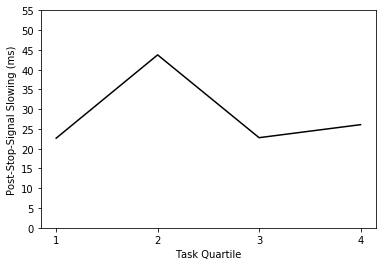

In [316]:
plt.plot(np.arange(1, 5, 1), [np.nanmean(first), np.nanmean(second), np.nanmean(third), np.nanmean(fourth)], color='black')
#plt.title('Post-Stop-Trial Slowing')
#plt.errorbar(np.arange(1, 5, 1), [np.nanmean(first), np.nanmean(second), np.nanmean(third), np.nanmean(fourth)], yerr=)
plt.ylabel('Post-Stop-Signal Slowing (ms)')
plt.xlabel('Task Quartile')
plt.xticks([1, 2, 3, 4])
plt.yticks(np.arange(0,60,5))
plt.savefig('task_quartile_slowing.png')
plt.show() #needs error bars?  


### Issue 6: Trial accuracy incorrectly coded

In [ ]:
#move from other notebook 

### Issue 7: SSD values start too short 

SSD starts at 50ms - this is really short

In [68]:
SST_concat.loc[SST_concat['StopTrial'] == 1]['SSDDur'].unique()

array([50.])

In [ ]:
num_stop = []
accuracy = [] 
mean_ssd = [] 
for i in np.arange(1, 61): 
    correct = SST_concat.loc[SST_concat['StopTrial'] ==i]['correct_stop'].value_counts()[1]
    acc = correct / len(SST_concat.loc[SST_concat['StopTrial'] ==i])
    ssd = np.mean(SST_concat.loc[SST_concat['StopTrial'] == i]['SSDDur'])
 
    num_stop.append(i)
    accuracy.append(acc)
    mean_ssd.append(ssd)
    
acc_df = pd.DataFrame() 
acc_df['StopTrial'] = num_stop 
acc_df['Accuracy'] = accuracy
acc_df['SSD'] = mean_ssd

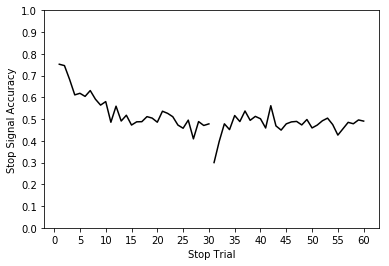

In [302]:
plt.plot(acc_df['StopTrial'][:30], acc_df['Accuracy'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['Accuracy'][30:], color='black')

plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Accuracy')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
#plt.axvline(x=30.5, color = 'grey', alpha = 1.0, lw=1.0, ls='--')
plt.yticks(np.arange(0,1.1, .1))
plt.xticks(np.arange(0,61,5))
plt.savefig('stop_signal_accuracy_across_stop_trial.png')
plt.show() #needs error bars 


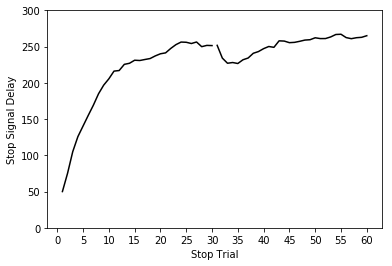

In [303]:
plt.plot(acc_df['StopTrial'][:30], acc_df['SSD'][:30], color='black')
plt.plot(acc_df['StopTrial'][30:], acc_df['SSD'][30:], color='black')

plt.xlabel('Stop Trial')
plt.ylabel('Stop Signal Delay')
#plt.title('Stop Signal Accuracy by Number of Stop Trial')
#plt.axvline(x=30.5, color = 'grey', alpha = 1.0, lw=1.0, ls='--')
plt.xticks(np.arange(0,61,5))
plt.yticks(np.arange(0, 350, 50))
plt.savefig('ssd_across_stop_trial.png')
plt.show()


#### Issue 8: Low stop probability 

In [347]:
len(SST_concat.loc[SST_concat['trial_type'] == 'StopTrial'])/ len(SST_concat)

0.16666666666666666